In [2]:
using PrettyPlot, JLD2, GLM, Dates, StatsBase, HypothesisTests, KernelDensity, PyPlot, LsqFit

In [3]:
function nanmean(x)  
    if sum(isnan.(x))==length(x)
        return NaN
    end
    mean(filter(!isnan,x))
end
nanmean(x,y) = mapslices(nanmean,x,y)
nanstd(x) = std(filter(!isnan,x))
nanstd(x,y) = mapslices(nanstd,x,y)

nanstd (generic function with 2 methods)

In [22]:
using DSP
function smooth(y, w_len=11, w_method=2)
    # This function requires the DSP package to be installed
    # 1: flat
    # 2: hanning
    # 3: hamming ...
    if w_len%2==0
        w_len+=1 #make odd for window length
    end
    if w_method == 1
        w=ones(w_len)
    elseif w_method == 2
        w=DSP.hanning(w_len)
    elseif w_method == 3
        w=DSP.hamming(w_len)
    end
    
    if (w_len < 3) || (length(y) < w_len) #not long enough
        return y
    else
        y_new = [2*y[1].-reverse(y[1:w_len],1); y[:]; 2*y[end].-reverse(y[end-w_len:end],1)]
        y_smooth = conv(y_new, w/sum(w))
        ind = floor(Int, 1.5*w_len)
        return y_smooth[1+ind:end-ind-1]
    end
end
function gauss4(x,a,b,c)
    return a.*broadcast(exp,(-((x.-b)./c).^2))
end
function stc(pstune, tdata, p0, runs=3)
    model(x, p) = p[1] * exp.(-1 .*((x.-rail(p[2])).^2) ./ (2 .*p[3].^2) )
    rng = 1:0.01:5
    ydata = pstune
    fit = curve_fit(model, tdata, ydata, p0)
    param = fit.param
    for ii in 1:runs
        fit = curve_fit(model, tdata, ydata, param) #run with initialized params at least once for more accurate fit
        param = fit.param
    end
    mdl = model(rng, param)
    return mdl, param, fit
end
function rail(ps)
    if ps < 1
        return 1
    elseif ps > 5
        return 5
    else
        return ps
    end
end

rail (generic function with 1 method)

In [5]:
function speeddecode(ps, pr, nr, e)
    s = 2^( sum((pr.-nr).*broadcast(log2,ps) ) / (e+sum(pr.-nr)) )
    return s
end

speeddecode (generic function with 1 method)

In [10]:
cd("C:\\Users\\scb47\\Documents\\MTdataprocess")
@load "MTdataProcessed.jld2" mdall predFRall dataFRall cohall spdall psall prefD imall eyeall metric_fail speedPulse cohPulse pulseTime
cd("C:\\Users\\scb47\\Documents\\MATLAB\\Figures")

In [11]:
xa_im=-400:900
for un in unique(mdall)
    if (sum(prefD[mdall.==un])/length(prefD[mdall.==un])) == 1 #no null direction
        ndx = findall(mdall.==un)
        deleteat!(mdall, ndx)
        deleteat!(predFRall, ndx)
        deleteat!(dataFRall, ndx)
        deleteat!(cohall, ndx)
        deleteat!(spdall, ndx)
        deleteat!(psall, ndx)
        deleteat!(prefD, ndx)
        deleteat!(imall, ndx)
        deleteat!(eyeall, ndx)
        deleteat!(metric_fail, ndx)
        deleteat!(speedPulse, ndx)
        deleteat!(cohPulse, ndx)
        deleteat!(pulseTime, ndx)
    end
end
ndx = findall(cohall.==70)
deleteat!(mdall, ndx)
deleteat!(predFRall, ndx)
deleteat!(dataFRall, ndx)
deleteat!(cohall, ndx)
deleteat!(spdall, ndx)
deleteat!(psall, ndx)
deleteat!(prefD, ndx)
deleteat!(imall, ndx)
deleteat!(eyeall, ndx)
deleteat!(metric_fail, ndx)
deleteat!(speedPulse, ndx)
deleteat!(cohPulse, ndx)
deleteat!(pulseTime, ndx)
w = findall((lg).<=x.<(lg+lg))
winmax100 = Vector{Real}(undef, 0)
for un in unique(mdall)
    ndx = findall((cohall.==100).& (mdall.==un))
    hld=[]
    for ii in ndx
        push!(hld, mean(dataFRall[ii][w]))
    end
    push!(winmax100, maximum(hld))
end
winmax100

188-element Array{Real,1}:
 48.29059829059829
 32.945736434108525
 21.42857142857143
 32.592592592592595
 60.416666666666664
 56.91056910569105
 86.58536585365856
 41.666666666666664
 89.9122807017544
 43.40277777777778
 51.736111111111114
 42.592592592592595
 43.61111111111111
  ⋮
 18.518518518518515
 18.88888888888889
 18.055555555555554
 15.517241379310347
  8.333333333333334
  3.3333333333333335
 21.212121212121215
  7.291666666666667
  5.5555555555555545
 13.440860215053762
 16.666666666666668
 13.235294117647063

<h3>F06</h3>

In [33]:
#pop comparisons
neuronSTC(x, p) = p[1] * exp.(-1 .*((x.-rail(p[2])).^2) ./ (2 .*p[3].^2) )
xbounds = sort(unique(vsam))
unm=unique(mdall)
cohs=[100,70,30,10]
spds=[2,4,8,16,32]
x=-400:5:900
lg=60
w=findall((0+lg).<=x.<(0+lg+lg))
crvs = Array{Array}(undef, length(unm), 4)
kp=[]
for nn in unm
    ndx = findall((mdall.==nn).&(prefD.==true).&(cohPulse.==0).&(speedPulse.==0))
    if length(ndx)<9
        continue
    end
    push!(kp, findfirst(nn.==unm))
    tmpH=[]
    tmpS=[]
    tmpFR=[]
    for ii in ndx
        push!(tmpH, cohall[ii])
        push!(tmpS, findfirst(spdall[ii].==spds))
        push!(tmpFR, mean(dataFRall[ii][w]))
    end
    for hh in 1:length(cohs)        
        crvs[findfirst(nn.==unm), hh] = hcat(tmpS[tmpH.==cohs[hh]], tmpFR[tmpH.==cohs[hh]])
    end
end
crvs=crvs[kp,:]
crvsNull = Array{Array}(undef, length(unm), 4)
kp=[]
for nn in unm
    ndx = findall((mdall.==nn).&(prefD.==false).&(cohPulse.==0).&(speedPulse.==0))
    if length(ndx)<9
        continue
    end
    push!(kp, findfirst(nn.==unm))
    tmpH=[]
    tmpS=[]
    tmpFR=[]
    for ii in ndx
        push!(tmpH, cohall[ii])
        push!(tmpS, findfirst(spdall[ii].==spds))
        push!(tmpFR, mean(dataFRall[ii][w]))
    end
    for hh in 1:length(cohs)        
        crvsNull[findfirst(nn.==unm), hh] = hcat(tmpS[tmpH.==cohs[hh]], tmpFR[tmpH.==cohs[hh]])
    end
end
crvsNull=crvsNull[kp,:]

162×4 Array{Array,2}:
 Real[1 18.75; 2 23.4375; … ; 4 18.2292; 5 24.7619]    …  Real[1 31.25; 2 27.0833; … ; 4 27.4194; 5 33.8542]
 Real[1 32.9457; 2 28.2946; … ; 4 30.9524; 5 31.3492]     Real[1 25.7937; 2 23.2558; … ; 4 27.907; 5 27.381]
 Real[1 8.91473; 2 7.75194; … ; 4 10.8527; 5 14.0741]     Real[1 13.1783; 2 15.1163; … ; 4 12.0155; 5 15.1163]
 Real[1 20.5426; 2 14.6825; … ; 4 18.6047; 5 29.5455]     Real[1 26.5873; 2 30.9524; … ; 4 26.5873; 5 28.5714]
 Real[1 11.5646; 2 8.0; … ; 4 7.66667; 5 17.6282]         Real[1 16.6667; 2 17.3759; … ; 4 17.3611; 5 17.3203]
 Real[1 14.2276; 2 15.873; … ; 4 19.9187; 5 21.0317]   …  Real[1 27.6423; 2 25.2033; … ; 4 34.5528; 5 44.4444]
 Real[1 28.0488; 2 22.619; … ; 4 28.4553; 5 39.2857]      Real[1 36.5854; 2 35.3659; … ; 4 42.6829; 5 48.0159]
 Real[1 3.75; 2 5.70175; … ; 4 7.69231; 5 17.4419]        Real[1 22.3684; 2 19.2982; … ; 4 17.1053; 5 21.3675]
 Real[1 12.9167; 2 14.0351; … ; 4 19.6581; 5 38.3721]     Real[1 50.0; 2 46.4912; … ; 4 39.912

In [23]:
#take the opponent speed tuning curves and fit them for the model rather than null and pref curves
PS = []
crvsOpp = Array{Array}(undef, size(crvs,1), 4)
for ii in 1:size(crvs,1)
    for jj in 1:4
        crvsOpp[ii,jj] = hcat(crvs[ii,jj][:,1], crvs[ii,jj][:,2].-crvsNull[ii,jj][:,2])
    end
    push!(PS, 2^findmax(crvsOpp[ii,1][:,2])[2])
end

prmsOpp = Array{Array}(undef, size(crvs,1), 3)

for ii in 1:size(crvsOpp,1)
    h=0
    for hh in [1,3,4]
        h+=1
        p0 = [maximum(crvsOpp[ii,hh][:,2]), findfirst(crvsOpp[ii,hh][:,2].==maximum(crvsOpp[ii,hh][:,2])), 0.5]
        _,params,_ = stc(crvsOpp[ii,hh][:,2], crvsOpp[ii,hh][:,1], p0)
        prmsOpp[ii,h] = ([params[1],params[3]])
    end
end

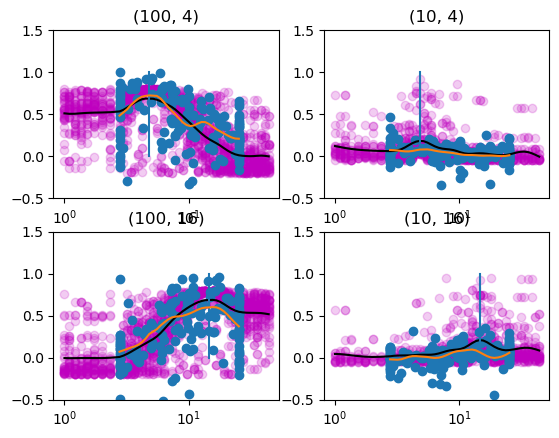

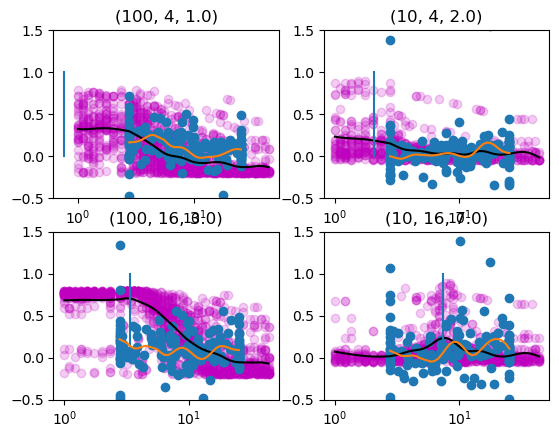

In [43]:
sam=0:0.125:6
vsam = repeat(sam,42)
vp = sample(1:size(prmsOpp,1), length(vsam))
f=0
hld=[]
w = findall((0+lg).<=x.<(0+lg+lg))
offset = [0.2,0.1,0.05]
for ss in [4,16]
    for hh in [100,10]
        h=findfirst([100,30,10].==hh)    
        fr=[]
        ps=[]
        for ii in 1:length(vp)
            p = [prmsOpp[vp[ii],h][1], vsam[ii], prmsOpp[vp[ii],h][2]]
            if 0.001 < (neuronSTC(log2(ss), p)/prmsOpp[vp[ii],1][1]) < 0.999 #don't forget to normalize by 100, not each coherence
                push!(fr, neuronSTC(log2(ss), p)/prmsOpp[vp[ii],1][1] - offset[h])#findmax(crvsOpp[vp[ii],1][:,2])[1])#prmsOpp[vp[ii],h][1]
                push!(ps, vsam[ii])
            end
            if (neuronSTC(log2(ss), p)/prmsOpp[vp[ii],h][1] == 0) || (neuronSTC(log2(ss), p)/prmsOpp[vp[ii],1][1] == 1)
                push!(hld, vp[ii])
            end
        end
        f+=1
        subplot(2,2,f)
        scatter(2 .^ ps, fr, alpha=0.2, color="m")
        title((hh,ss))
        
        xscale("symlog")
        
        l1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in xbounds
            ndx = findall(ii .== (ps))
            if isempty(ndx)
                continue
            end
            push!(l1, mean(fr[ndx]))
            push!(x1, ii)
        end
        plot(2 .^x1, smooth(l1),"k")
        plot([ss,ss],[0,1])
        
        #add data
        ps=[]
        fr=[]
        nfr=[]
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            push!(ps, psall[ii])
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==false).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        scatter(ps, fr.-nfr)
        ld1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in 2:length(xbounds)
            ndx = findall(2^xbounds[ii-1] .<= ps .< 2^xbounds[ii])
            if isempty(ndx)
                continue
            end
            push!(ld1, mean((fr.-nfr)[ndx]))    
            push!(x1, 2^xbounds[ii-1])
        end
        plot(x1, smooth(ld1))     
        ylim([-0.5,1.5])
    end
end
sort(unique(hld))
#save_figure_composer("stctestOpp.fyp")
figure()
w = findall((500+lg).<=x.<(500+lg+lg))
iw = findall(500 .<=xa_im.<=lg+500)
f=0
for ss in [4,16]
    for hh in [100,10]
        h=findfirst([100,30,10].==hh)    
        fr=[]
        ps=[]
        ihld=[]
        ndx = findall((ss.==spdall).&(hh.==cohall).&(speedPulse.==0).&(cohPulse.==0).&(prefD.==true))
        for ii in ndx
            push!(ihld, nanmean(imall[ii][iw]))
        end
        imm=nanmean(ihld)
        for ii in 1:length(vp)
            p = [prmsOpp[vp[ii],h][1], vsam[ii], prmsOpp[vp[ii],h][2]]
            if 0.001 < (neuronSTC(log2(imm), p)/prmsOpp[vp[ii],1][1]) < 0.999 #don't forget to normalize by 100, not each coherence
                push!(fr, neuronSTC(log2(imm), p)/prmsOpp[vp[ii],1][1] - offset[h])#findmax(crvsOpp[vp[ii],1][:,2])[1])#prmsOpp[vp[ii],h][1]
                push!(ps, vsam[ii])
            end           
        end
        f+=1
        subplot(2,2,f)
        scatter(2 .^ ps, fr, alpha=0.2, color="m")
        title((hh,ss,round(imm)))
        xscale("symlog")
        
        l1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in xbounds
            ndx = findall(ii .== (ps))
            if isempty(ndx)
                continue
            end
            push!(l1, mean(fr[ndx]))
            push!(x1, ii)
        end
        plot(2 .^x1, smooth(l1),"k")
        plot([imm,imm],[0,1])
        
        #add data
        ps=[]
        fr=[]
        nfr=[]
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            push!(ps, psall[ii])
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==false).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        scatter(ps, fr.-nfr)
        ld1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in 2:length(xbounds)
            ndx = findall(2^xbounds[ii-1] .<= ps .< 2^xbounds[ii])
            if isempty(ndx)
                continue
            end
            push!(ld1, mean((fr.-nfr)[ndx]))    
            push!(x1, 2^xbounds[ii-1])
        end
        plot(x1, smooth(ld1))     
        ylim([-0.5,1.5])
    end
end

#save_figure_composer("stctestOppSS.fyp")

<h3>F07</h3>

In [6]:
cd("C:\\Users\\scb47\\Documents\\MTdataprocess")
@load "modelfreepop.jld2" foundation foundationNull modulationH modulationHnull modulationSP modulationSPnull
cd("C:\\Users\\scb47\\Documents\\MATLAB\\Figures")

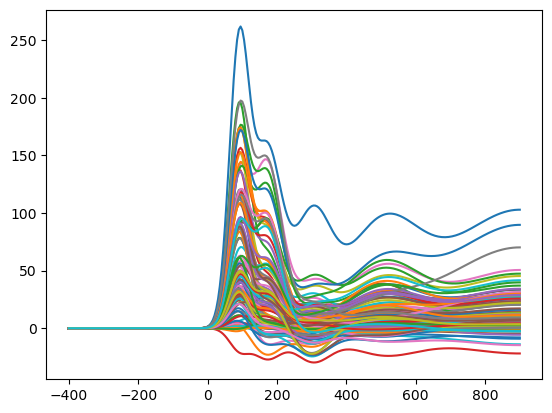

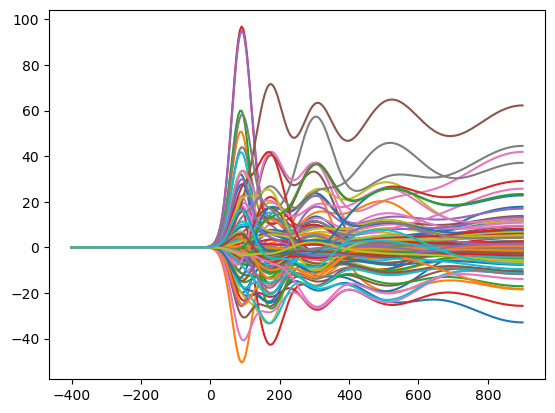

100

In [7]:
binsz = 0.005
x=(-0.4:binsz:0.9) * 1000
modelneuron(x,p) = gauss4(x,p[1],90,40).+gauss4(x,p[2],170,60).+gauss4(x,p[3],300,75).+gauss4(x,p[4],500,150).+gauss4(x,p[5],900,300).+p[6]
for ii in 1:length(foundation)
    plot(x, modelneuron(x, foundation[ii]) .- foundation[ii][end])
end
#save_figure_composer("pref5gmodel.fyp")
figure()
for ii in 1:length(foundationNull)
    plot(x, modelneuron(x, foundationNull[ii]) .- foundationNull[ii][end])
end
#save_figure_composer("null5gmodel.fyp")
#baseline subtracted
length(foundation)

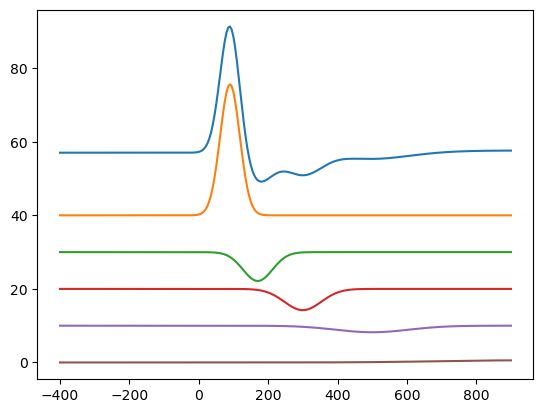

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005F08F2B0>

In [8]:
plot(x, modelneuron(x, foundation[78]).+50) 
p=foundation[78]
plot(x, gauss4(x,p[1],90,40).+40)#first
plot(x, gauss4(x,p[2],170,60).+30)#second
plot(x, gauss4(x,p[3],300,75).+20)#third
plot(x, gauss4(x,p[4],500,150).+10)#fourth
plot(x, gauss4(x,p[5],900,300))#fifth

In [44]:
sam=0:0.125:6
vsam = repeat(sam,42)
vp = sample(1:length(foundation), length(vsam))
println(length(vp))

lg=60
w = findall((lg).<=x.<(lg+lg))
nm=[]
bb=[]
for kk in 1:length(vsam)
    push!(nm, mean(modelneuron(x, foundation[vp[kk]])[w]))
    push!(bb, foundation[vp[kk]][end])
end

2058


In [49]:
simspds

1976-element Array{Any,1}:
 0.0
 0.125
 0.25
 0.375
 0.5
 0.625
 0.75
 0.875
 1.0
 1.125
 1.25
 1.375
 1.5
 ⋮
 4.625
 4.75
 4.875
 5.0
 5.125
 5.25
 5.375
 5.5
 5.625
 5.75
 5.875
 6.0

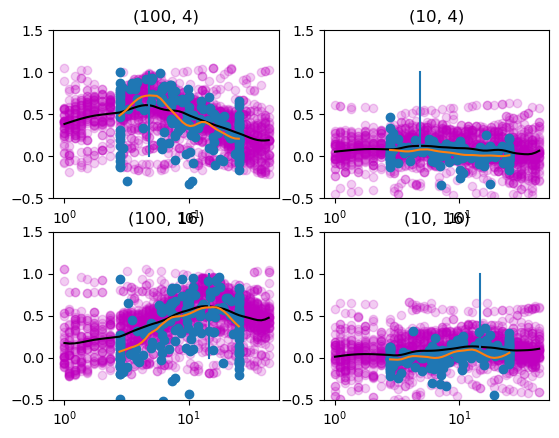

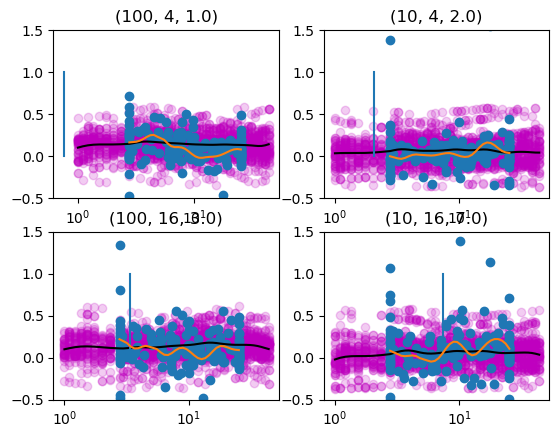

In [50]:
#pop comparisons
f=0
hld=[]
w = findall((lg).<=x.<(lg+lg))
offset = [0.2,0.1,0.05]
for ss in [4,16]
    for hh in [100,10]
        h=findfirst([100,30,10].==hh)    
        FR=[]
        nFR=[]
        simspds=[]
        for kk in 1:length(vp)
            d = abs(vsam[kk]-log2(ss))
            push!(FR, mean(modelneuron(x,foundation[vp[kk]] .* modulationH[vp[kk]][h] .+ d.*modulationSP[vp[kk]][h])[w] ./nm[kk]))
            push!(nFR, mean(modelneuron(x, foundationNull[vp[kk]] .* modulationHnull[vp[kk]][h] .+ d.*modulationSPnull[vp[kk]][h])[w] ./nm[kk]))
            push!(simspds, vsam[kk])
        end
        ndx=findall((FR.-nFR).>(mean(FR.-nFR)+std(FR.-nFR)*2))   
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        ndx=findall((FR.-nFR).<(mean(FR.-nFR)-std(FR.-nFR)*2))    
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        
        f+=1
        subplot(2,2,f)
        scatter(2 .^ simspds, FR.-nFR, alpha=0.2, color="m")
        title((hh,ss))        
        xscale("symlog")
        
        l1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in xbounds
            ndx = findall(ii .== (simspds))
            if isempty(ndx)
                continue
            end
            push!(l1, mean((FR.-nFR)[ndx]))
            push!(x1, ii)
        end
        plot(2 .^x1, smooth(l1),"k")
        plot([ss,ss],[0,1])
        
        #add data
        ps=[]
        fr=[]
        nfr=[]
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            push!(ps, psall[ii])
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==false).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        scatter(ps, fr.-nfr)
        ld1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in 2:length(xbounds)
            ndx = findall(2^xbounds[ii-1] .<= ps .< 2^xbounds[ii])
            if isempty(ndx)
                continue
            end
            push!(ld1, mean((fr.-nfr)[ndx]))    
            push!(x1, 2^xbounds[ii-1])
        end
        plot(x1, smooth(ld1))     
        ylim([-0.5,1.5])
    end
end
sort(unique(hld))
#save_figure_composer(".fyp")
figure()
w = findall((500+lg).<=x.<(500+lg+lg))
iw = findall(500 .<=xa_im.<=lg+500)
f=0
for ss in [4,16]
    for hh in [100,10]
        h=findfirst([100,30,10].==hh) 
        ihld=[]
        ndx = findall((ss.==spdall).&(hh.==cohall).&(speedPulse.==0).&(cohPulse.==0).&(prefD.==true))
        for ii in ndx
            push!(ihld, nanmean(imall[ii][iw]))
        end
        imm=nanmean(ihld)
        FR=[]
        nFR=[]
        simspds=[]
        for kk in 1:length(vp)
            d = abs(vsam[kk]-log2(ss))
            push!(FR, mean(modelneuron(x,foundation[vp[kk]] .* modulationH[vp[kk]][h] .+ d.*modulationSP[vp[kk]][h])[w] ./nm[kk]))
            push!(nFR, mean(modelneuron(x, foundationNull[vp[kk]] .* modulationHnull[vp[kk]][h] .+ d.*modulationSPnull[vp[kk]][h])[w] ./nm[kk]))
            push!(simspds, vsam[kk])
        end
        ndx=findall((FR.-nFR).>(mean(FR.-nFR)+std(FR.-nFR)*2))   
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        ndx=findall((FR.-nFR).<(mean(FR.-nFR)-std(FR.-nFR)*2))    
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        
        f+=1
        subplot(2,2,f)
        scatter(2 .^ simspds, FR.-nFR, alpha=0.2, color="m")
        title((hh,ss,round(imm)))
        xscale("symlog")
        
        l1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in xbounds
            ndx = findall(ii .== (simspds))
            if isempty(ndx)
                continue
            end
            push!(l1, mean((FR.-nFR)[ndx]))
            push!(x1, ii)
        end
        plot(2 .^x1, smooth(l1),"k")
        plot([imm,imm],[0,1])
        
        #add data
        ps=[]
        fr=[]
        nfr=[]
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==true).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx            
            n = findfirst(mdall[ii].==unm)
            push!(ps, psall[ii])
            push!(fr, mean(dataFRall[ii][w])/winmax100[n])
        end
        ndx = findall((spdall.==ss).&(cohall.==hh).&(prefD.==false).&(speedPulse.==0).&(cohPulse.==0))
        for ii in ndx
            n = findfirst(mdall[ii].==unm)
            push!(nfr, mean(dataFRall[ii][w])/winmax100[n])
        end
        scatter(ps, fr.-nfr)
        ld1=Vector{Float64}(undef, 0)
        x1=Vector{Float64}(undef, 0)
        for ii in 2:length(xbounds)
            ndx = findall(2^xbounds[ii-1] .<= ps .< 2^xbounds[ii])
            if isempty(ndx)
                continue
            end
            push!(ld1, mean((fr.-nfr)[ndx]))    
            push!(x1, 2^xbounds[ii-1])
        end
        plot(x1, smooth(ld1))     
        ylim([-0.5,1.5])
    end
end

100
-0.17787429088483794
0.025855555855727453
30
-0.023188997297261916
0.12306652337117137
10
-0.026823293949373182
-0.016349018856209162


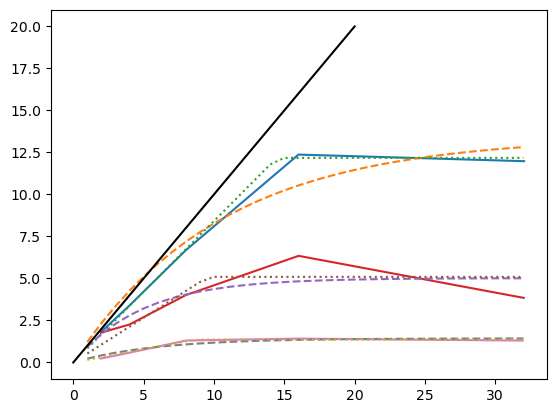

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005F30C400>

In [12]:
#get functions of image motion and eye speed for extrapolating targets
lg=60
w = findall((lg).<=x.<(lg+lg))
iw = findall(0 .<=xa_im.<=lg)
ew = findall(195 .<=xa_im .<=205)

logm(x, p) = p[1] .* (1 .-exp.(-p[2] .*x))
linplatm(x,p) = ifelse.((x.*p[2]).<p[1], x.*p[2], p[1])

p1=[]
p2=[]

for hh in [100, 30, 10]#10
    IM = []
    #E1 = []
    E2=[]
    for ss in [2, 4, 8, 16, 32]#32
        ndx = findall((cohall.==hh).& (spdall.==ss).& (prefD.==true).& (metric_fail.==false))
        if isempty(ndx)
            continue
        end
        im=[]
        #em1=[]
        em2=[]
        for ii in 1:length(ndx)
            push!(im, nanmean(imall[ndx[ii]][iw])) 
            #push!(em1, eyeall[ndx[ii]][iw[end]+lg+lg]-eyeall[ndx[ii]][iw[end]]) 
            push!(em2, mean(eyeall[ndx[ii]][ew]))
        end
        push!(IM, nanmean(im))
        #push!(E1, nanmean(em1))
        push!(E2, nanmean(em2))
    end   
    #plot(IM, E1, "r")
    plot(IM, E2)
    println(hh)
    fit = curve_fit(logm, IM, E2, [10,0.1])
    params=fit.param
    println(mean(E2.-logm(IM, params)))
    plot(1:32, logm(1:32, params),"--")
    push!(p1, params)
    
    fit = curve_fit(linplatm, IM, E2, [10,0.9])
    params=fit.param
    println(mean(E2.-linplatm(IM, params)))
    plot(1:32, linplatm(1:32, params),":")
    push!(p2, params)
    
end
plot([0,20],[0,20],"k")

<h3>F08</h3>

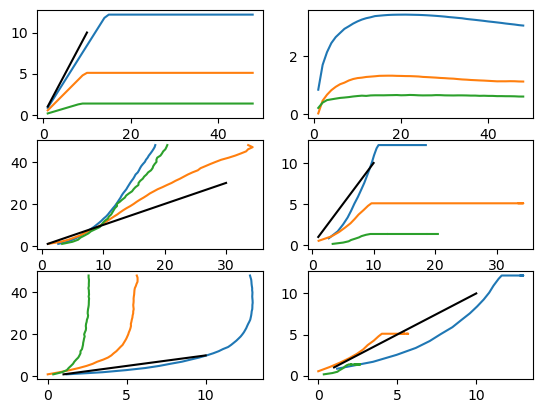

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000005F0F4438>

In [16]:
c=875
mp=0
i6=[]
e6=[]
v6=[]
g6=[]
d6=[]
for hh in [100, 30, 10]
    mp+=1
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in 1:48
        FR=[]
        nFR=[]
        simspds=[]
        for kk in 1:length(vsam)
            d = abs(vsam[kk]-log2(ss))
            push!(FR, mean(modelneuron(x,foundation[vp[kk]] .* modulationH[vp[kk]][mp] .+ d.*modulationSP[vp[kk]][mp])[w] ./nm[kk]))
            push!(nFR, mean(modelneuron(x, foundationNull[vp[kk]] .* modulationHnull[vp[kk]][mp] .+ d.*modulationSPnull[vp[kk]][mp])[w] ./nm[kk]))
            push!(simspds, vsam[kk])
        end
        ndx=findall((FR.-nFR).>(mean(FR.-nFR)+std(FR.-nFR)*2))  #1.1  
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        ndx=findall((FR.-nFR).<(mean(FR.-nFR)-std(FR.-nFR)*2))  #-1.1)   
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        
        push!(VA, speeddecode(2 .^simspds, FR, nFR, 0.05))
        push!(IM, ss)
        push!(E, linplatm(ss, p2[mp]))
        g = 1/c * sum((FR.-nFR).*broadcast(log2, 2 .^simspds)) 
        push!(dcode, g*log2(speeddecode(2 .^simspds, FR, nFR, 0.05)))
        push!(G, g)
    end 
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
    push!(g6, G)
    push!(d6, dcode)
end
subplot(3,2,1)
for ii in 1:3; plot(i6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,2)
for ii in 1:3; plot(i6[ii], g6[ii]); end
subplot(3,2,3)
for ii in 1:3; plot(v6[ii], i6[ii]); end
plot([1,30],[1,30],"k")
subplot(3,2,4)
for ii in 1:3; plot(v6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,5)
for ii in 1:3; plot(d6[ii], i6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,6)
for ii in 1:3; plot(d6[ii], e6[ii]); end
plot([1,10],[1,10],"k")

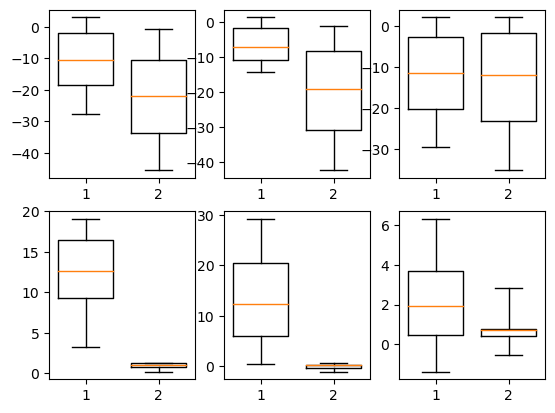

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…

In [17]:
subplot(2,3,1)
PyPlot.boxplot([v6[3].-i6[3],d6[3].-i6[3]], widths=0.75)
subplot(2,3,2)
PyPlot.boxplot([v6[2].-i6[2],d6[2].-i6[2]], widths=0.75)
subplot(2,3,3)
PyPlot.boxplot([v6[1].-i6[1],d6[1].-i6[1]], widths=0.75)

subplot(2,3,4)
PyPlot.boxplot([v6[3].-e6[3],d6[3].-e6[3]], widths=0.75)
subplot(2,3,5)
PyPlot.boxplot([v6[2].-e6[2],d6[2].-e6[2]], widths=0.75)
subplot(2,3,6)
#PyPlot.boxplot([v6[1].-e6[1],d6[1].-e6[1]], widths=0.75)
PyPlot.boxplot([v6[1].-e6[1],d6[1].-e6[1]], widths=0.75, whis=99) #think about how to show outliers if needed

#save_figure_composer("extcomp.fyp")

[0.23013538430162708, 0.18731951965517146, 0.11799547190192569, 0.16457036217770432, 0.31671103193647737]
0.20334635399458117
100
-3.4750108623970987e-10
[0.13909250920484145, 0.3376207965411258, 0.31022843686919743, 0.3613844728932356, 0.3925044650425656]
0.30816613611019317
30
-6.110001393722086e-13
[0.31790615318278453, 0.49885314324831836, 0.39363494831143264, 0.49586588422787525, 0.4479374056885893]
0.4308395069318
10
9.703571279828794e-13


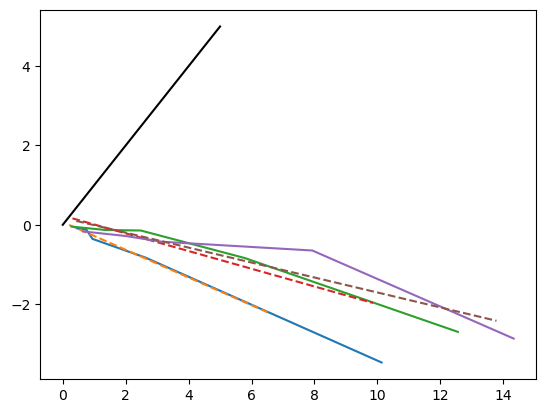

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000062CEF048>

In [30]:
#model of steady-state change in eye speeds and image motion
lg=60
tt=600
w = findall((lg+tt).<=x.<(lg+lg+tt))
iw = findall(tt .<=xa_im.<=lg+tt)
#ew = findall(695 .<=xa_im .<=705)

logm(x, p) = p[1] .* (1 .-exp.(-p[2] .*x))
linplatn(x,p) = ifelse.(x.<p[3], p[1] .* x .+ p[2], p[4] .* x .+ p[5])
#ss looks straight linear
lin(x,p) = p[1] .* x .+ p[2]

p1=[]
slips=[]
mp=0
for hh in [100, 30, 10]#10
    mp+=1
    IM = []
    #E1 = []
    E2=[]
    for ss in [2, 4, 8, 16, 32]#32
        ndx = findall((cohall.==hh).& (spdall.==ss).& (prefD.==true).& (speedPulse.==0) .& (cohPulse.==0))
        if isempty(ndx)
            continue
        end
        im=[]
        #em1=[]
        em2=[]
        for ii in 1:length(ndx)
            push!(im, nanmean(imall[ndx[ii]][iw])) 
            #push!(em1, eyeall[ndx[ii]][iw[end]+lg+lg]-eyeall[ndx[ii]][iw[end]]) 
            push!(em2, eyeall[ndx[ii]][iw[end]+120]-eyeall[ndx[ii]][iw[end]])    
        end
        push!(IM, nanmean(im))
        #push!(E1, nanmean(em1))
        push!(E2, nanmean(em2))
    end  
    println(IM./[2,4,8,16,32])
    println(mean(IM./[2,4,8,16,32]))
    push!(slips, mean(IM./[2,4,8,16,32]))
    #plot(IM, E1, "r")
    plot(IM, E2)
    println(hh)
    fit = curve_fit(lin, IM, E2, [-0.5,0])
    params=fit.param
    println(mean(E2.-lin(IM, params)))
    plot((1:32).*slips[mp], lin((1:32).*slips[mp], params),"--")
    push!(p1, params)    
    
    #fit = curve_fit(linplatn, IM, E2, [0, 0, 2, -0.5, 0])
    #params=fit.param
    #plot((1:32).*slips[mp], linplatn((1:32).*slips[mp], params), ":")
    
end
plot([0,5],[0,5],"k")
#save_figure_composer("test1220.fyp")

<h3>F09</h3>

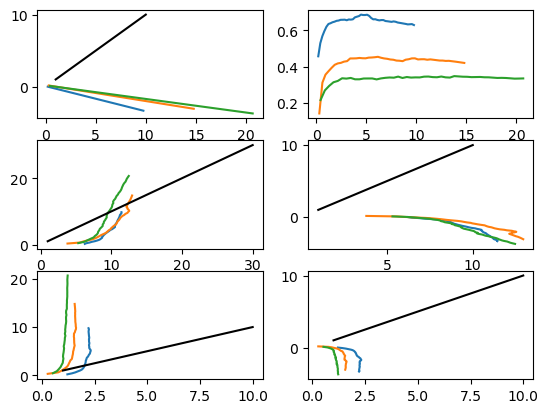

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000007DBC780>

In [31]:
#steady-state 
c=1000
mp=0
i6=[]
e6=[]
v6=[]
g6=[]
d6=[]
for hh in [100, 30, 10]#10
    mp+=1
    VA = []
    IM = []
    E = []
    dcode = []
    G = []
    for ss in 1:48
        FR=[]
        nFR=[]
        simspds=[]
        for kk in 1:length(vsam)
            d = abs(vsam[kk]-log2(ss))
            push!(FR, mean(modelneuron(x,foundation[vp[kk]] .* modulationH[vp[kk]][mp] .+ d.*modulationSP[vp[kk]][mp])[w] ./nm[kk]))
            push!(nFR, mean(modelneuron(x, foundationNull[vp[kk]] .* modulationHnull[vp[kk]][mp] .+ d.*modulationSPnull[vp[kk]][mp])[w] ./nm[kk]))
            push!(simspds, vsam[kk])
        end
        ndx=findall((FR.-nFR).>(mean(FR.-nFR)+std(FR.-nFR)*2))  #1.1  
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        ndx=findall((FR.-nFR).<(mean(FR.-nFR)-std(FR.-nFR)*2))  #-1.1)   
        deleteat!(FR, ndx)
        deleteat!(nFR, ndx)
        deleteat!(simspds, ndx)
        
        push!(VA, speeddecode(2 .^simspds, FR, nFR, 0.05))
        push!(IM, ss*slips[mp])
        push!(E, lin(ss*slips[mp], p1[mp]))
        g = 1/c * sum((FR.-nFR).*broadcast(log2, 2 .^simspds)) 
        push!(dcode, g*log2(speeddecode(2 .^simspds, FR, nFR, 0.05)))
        push!(G, g)
    end  
    push!(i6, IM)
    push!(e6, E)
    push!(v6, VA)
    push!(g6, G)
    push!(d6, dcode)
end
subplot(3,2,1)
for ii in 1:3; plot(i6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,2)
for ii in 1:3; plot(i6[ii], g6[ii]); end
subplot(3,2,3)
for ii in 1:3; plot(v6[ii], i6[ii]); end
plot([1,30],[1,30],"k")
subplot(3,2,4)
for ii in 1:3; plot(v6[ii], e6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,5)
for ii in 1:3; plot(d6[ii], i6[ii]); end
plot([1,10],[1,10],"k")
subplot(3,2,6)
for ii in 1:3; plot(d6[ii], e6[ii]); end
plot([1,10],[1,10],"k")

#save_figure_composer("simSSpop600.fyp")

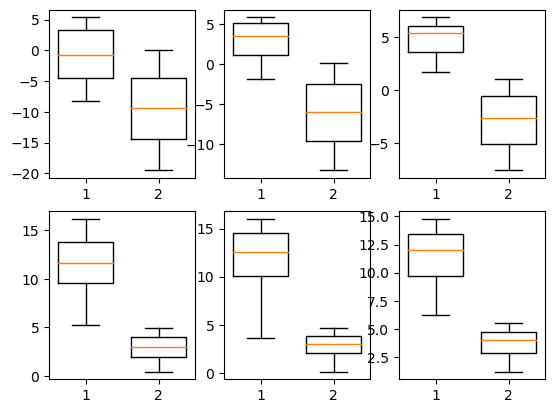

Dict{Any,Any} with 6 entries:
  "means"    => Any[]
  "whiskers" => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "fliers"   => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "boxes"    => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "caps"     => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…
  "medians"  => PyCall.PyObject[PyObject <matplotlib.lines.Line2D object at 0x0…

In [32]:
subplot(2,3,1)
PyPlot.boxplot([v6[3].-i6[3],d6[3].-i6[3]], widths=0.75)
subplot(2,3,2)
PyPlot.boxplot([v6[2].-i6[2],d6[2].-i6[2]], widths=0.75)
subplot(2,3,3)
PyPlot.boxplot([v6[1].-i6[1],d6[1].-i6[1]], widths=0.75)

subplot(2,3,4)
PyPlot.boxplot([v6[3].-e6[3],d6[3].-e6[3]], widths=0.75)
subplot(2,3,5)
PyPlot.boxplot([v6[2].-e6[2],d6[2].-e6[2]], widths=0.75)
subplot(2,3,6)
PyPlot.boxplot([v6[1].-e6[1],d6[1].-e6[1]], widths=0.75)

#save_figure_composer("simSScmpr600.fyp")